# Ice rise temperature profile MCMC inversion

*References:*

Inversion code and forward model:

Montelli, A. and Kingslake, J. (2023). Geothermal heat flux is the dominant source of uncertainty in englacial-temperature-based dating of ice rise formation. The Cryosphere, 17(1), pp.195–210. doi:https://doi.org/10.5194/tc-17-195-2023.

Heat flow data:

Hazzard, J.A.N. and Richards, F.D. (2024). Antarctic Geothermal Heat Flow, Crustal Conductivity and Heat Production Inferred From Seismological Data. Geophysical Research Letters, 51(7). doi:https://doi.org/10.1029/2023gl106274.

Ice rise data:

Bindschadler, R.A., Roberts, E.P. and Iken, A. (1990). Age of Crary Ice Rise, Antarctica, Determined from Temperature-Depth Profiles. Annals of Glaciology, 14, pp.13–16. doi:https://doi.org/10.3189/s0260305500008168.

Dahl-Jensen, D., Morgan, V.I. and Elcheikh, A. (1999). Monte Carlo inverse modelling of the Law Dome (Antarctica) temperature profile. Annals of Glaciology, 29, pp.145–150. doi:https://doi.org/10.3189/172756499781821102.

Engelhardt, H. (2004). Ice temperature and high geothermal flux at Siple Dome, West Antarctica, from borehole measurements. Journal of Glaciology, 50(169), pp.251–256. doi:https://doi.org/10.3189/172756504781830105.

Massam, A. (2017). Modelling the age-depth and temperature profiles of deep ice cores from the Antarctic Peninsula and the Weddell Sea region.

Morgan, V.I., Wookey, C.W., Li, J., van Ommen, T.D., Skinner, W. and Fitzpatrick, Μ.F. (1997). Site information and initial results from deep ice drilling on Law Dome, Antarctica. Journal of Glaciology, 43(143), pp.3–10. doi:https://doi.org/10.3189/s0022143000002768.

Mulvaney, R., Rix, J., Polfrey, S., Grieman, M., Martìn, C., Nehrbass-Ahles, C., Rowell, I., Tuckwell, R. and Wolff, E. (2021). Ice drilling on Skytrain Ice Rise and Sherman Island, Antarctica. Annals of Glaciology, [online] 62(85-86), pp.311–323. doi:https://doi.org/10.1017/aog.2021.7.

Mulvaney, R., Triest, J. and Alemany, O. (2014). The James Ross Island and the Fletcher Promontory ice-core drilling projects. Annals of Glaciology, 55(68), pp.179–188. doi:https://doi.org/10.3189/2014aog68a044.


#### *Importing the required modules*

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import time
import math
import random
import time
import dask
import dask.bag as db
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline
import emcee # need to run in terminal beforehand: 'conda install -c conda-forge emcee'
from tqdm import tqdm
import h5py
import matplotlib.font_manager
from netCDF4 import Dataset 
import netCDF4 as nc
import xarray as xr
import gcsfs
import fsspec
import cartopy.crs as ccrs
import cmocean
import multiprocess as mp

#### *Setting up plotting parameters*

In [2]:
# mpl.rcParams['figure.figsize'] = 5.0, 3.0 
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 200
plt.rcParams.update({
    'font.sans-serif': 'Arial', # need to run conda install -c conda-forge -y mscorefonts for Arial
    'font.family': 'Arial',
    'font.size': 11,
    'figure.titlesize': 12,
    'figure.titleweight': 'bold',
    'lines.linewidth' : 0.5,
    'lines.markersize' : 2,
    'xtick.labelsize' : 10,
    'ytick.labelsize' : 10,
    'grid.linewidth': 0.1,
    'axes.titlesize': 11,
    'axes.titleweight' : 'bold',
    'axes.labelsize': 11,
    'axes.labelweight': 'bold',
    'axes.linewidth': 0.5,
    'pdf.fonttype': 42
})

## Ice rise temperature profiles

*Table of key values and parameters:*

|	| Longitude | Latitude | x | y | GHF Mean | GHF Local deviation | GHF Total deviation | Ice thickness |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
|Crary Ice Rise	|-172.8	|-83.00	|-95.00	|-756.08	|108.36	|7.09	|11.51	|480 |
|Skytrain Ice Rise	|-78.5	|-79.67	|-1103.04	|224.42	|92.19	|16.19	|18.64	|651 |
|Siple Dome	|-148.8	|-81.66	|-470.33	|-776.60	|106.09	|6.87	|10.01	|1005 |
|Law Dome	|112.8	|-66.77	|2357.90	|-991.17	|38.78	|3.28	|4.43	|1196 |
|Fletcher Promontory	|-82.6	|-77.90	|-1308.09	|169.89	|81.14	|18.32	|18.95	|654 |
|Berkner Island	|-45.7	|-79.55	|-814.78	|795.11	|67.76	|15.83	|18.17	|948 |


Positions given are those of the borehole.  
x and y refer to the Polar Stereographic coordinates (km).  
Geothermal heat flow (GHF) values are given in mW (Hazzard & Richards, 2024).  
Ice thickness is borehole depth to bedrock in m.  

### Resampling and plotting temperature profiles

In [3]:
Crary_T_profile = np.genfromtxt('Binschadler_Crary_D_Temps.txt', delimiter='\t', skip_header=1)
Skytrain_T_profile = np.genfromtxt('skytrain_temp_profile.csv', delimiter=',', skip_header=1)
Siple_T_profile = np.genfromtxt('siple_dome.csv', delimiter=',', skip_header=1)
Law_T_profile = np.genfromtxt('law_dome.csv', delimiter=',', skip_header=1)
Fletcher_T_profile = np.genfromtxt('fletcher_promontory.csv', delimiter=',', skip_header=1)
Berkner_T_profile = np.genfromtxt('berkner_island.csv', delimiter=',', skip_header=1)

In [4]:
def rsmpl(T_in, z_in, dz):
    flinear = interp1d(z_in, T_in, fill_value='extrapolate')
    
    z_out = np.arange(0, int(max(z_in))+dz, dz)
    T_out = flinear(z_out)
    
    return [T_out, z_out]

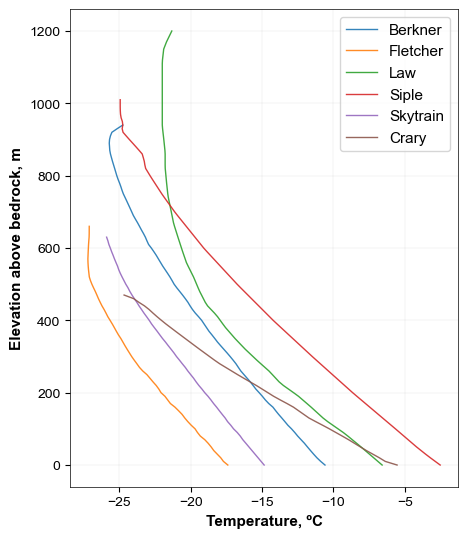

In [5]:
T_interp_skytrain = rsmpl(Skytrain_T_profile[:,0],Skytrain_T_profile[:,1], 10)
T_interp_siple = rsmpl(Siple_T_profile[:,0],Siple_T_profile[:,1], 10)
T_interp_law = rsmpl(Law_T_profile[:,0],Law_T_profile[:,1], 10)
T_interp_fletcher = rsmpl(Fletcher_T_profile[:,0],Fletcher_T_profile[:,1], 10)
T_interp_berkner = rsmpl(Berkner_T_profile[:,0],Berkner_T_profile[:,1], 10)
T_interp_crary = rsmpl(Crary_T_profile[:,0],Crary_T_profile[:,1], 10)

##### Plotting the resampled profiles
plt.figure(figsize=(5, 6.2))
plt.plot(T_interp_berkner[0],T_interp_berkner[1], linewidth=1, alpha=0.9,  label='Berkner')
plt.plot(T_interp_fletcher[0],T_interp_fletcher[1], linewidth=1, alpha=0.9,  label='Fletcher')
plt.plot(T_interp_law[0],T_interp_law[1], linewidth=1, alpha=0.9,  label='Law')
plt.plot(T_interp_siple[0],T_interp_siple[1], linewidth=1, alpha=0.9,  label='Siple')
plt.plot(T_interp_skytrain[0],T_interp_skytrain[1], linewidth=1, alpha=0.9,  label='Skytrain')
plt.plot(T_interp_crary[0],T_interp_crary[1], linewidth=1, alpha=0.9,  label='Crary')
plt.ylabel('Elevation above bedrock, m')
plt.xlabel('Temperature, ºC')
plt.grid()
plt.legend()



## Defining the forward model

### Loading the required parameters for temperature calculation

In [6]:
c_i = 2e3 # Heat capacity of ice
c_r = 7.9e2 # Heat capacity of basal rock
k_i = 2.3 # Thermal conductivity of ice
k_r = 2.8 # Thermal conductivity of basal rock
rho_i = 918.9 # Density of ice
rho_r = 2750 # Density of basal rock
alpha_i = k_i / rho_i / c_i # Alpha for ice
alpha_r = k_r / rho_r / c_r # Alpha for basal rock
n = 3 # Glen's flow law exponent
g = 9.81 # Gravitational acceleration
A = 2e-16 # Rheological constant determining soft ice as a function of temperature

yr_to_s = 365.25*24*60*60 # Seconds in a year
dt_years = 1  # Temporal resolution / time step in years
dt = (dt_years*yr_to_s) #  Temporal resolution / calculation of time step in seconds

### Defining a simplified forward model function

In [7]:
def model_measured(theta, z):
    
    Hinitial, t_grounding, G, a_yr, T_sim = theta
    a = a_yr/yr_to_s
    
    Hisim = [Hinitial, Hend]
    
    dHyr = (Hend-Hinitial)/t_grounding
    dH = dHyr/yr_to_s

    time_sim_Hi = np.linspace(1, int(t_grounding), num=len(Hisim))
    tmnew = np.linspace(1, int(t_grounding), int(t_grounding), endpoint=True)
    fthk = interp1d(time_sim_Hi, Hisim)
    thkhistory = fthk(tmnew)

    dzr = 10
    dz = dzr
    zi = np.linspace(0, int(Hinitial), int((Hinitial)/dz) + 1)   # Space calculation domain for ice and rock

    zr = np.linspace(-Hr, 0, int(Hr/dz) + 1) #  Space calculation domain for rock
    l = len(zr)  # Index for ice-bed interface to be used in the loop calculations
    Lzi = len(zi) #  Number of elements in space domain for ice
    Lzr = len(zr) #  Number of elements in space domain for ice

    z = np.concatenate((zr[:-1],zi))
    Lz = len(z)

    Ts_surf_steady = T_sim
    Ts = -z*0 + Ts_surf_steady

    for i in range(0, int(15e3)):

        Hi = thkhistory[0]
        zi = np.linspace(0, int(Hi), Lzi)
        dz = int(Hi/Lzi)

        z = np.concatenate((zr[:-1],zi))

        # Ice shelf vertical velocity profile

        w = -np.linspace(a,a,Lzi) # Accumulation rate and basal melt/freeze rate are in balance

        # Above ice-rock interface

        Ts[l:-1] = Ts[l:-1] + dt*(alpha_i*(Ts[l+1:]-2*Ts[l:-1]+Ts[l-1:-2])/dz**2 - np.multiply(w[1:-1],(Ts[l+1:]-Ts[l-1:-2])/(2*dz)))
        Ts[-1] = Ts_surf_steady # Temperature forcing is constant and equals the first value of the imported Monte-Carlo surface temperature vectors

        Ts[l-1] = -1.89 - 7.53e-4*Hi


        # Below ice-rock interface

        Ts[1:l-1] = Ts[1:l-1] + dt*alpha_r*(Ts[2:l]-2*Ts[1:l-1]+Ts[0:l-2])/dzr**2
        Ts[0] = Ts[1] + (G/k_r*dzr)

        # Recording the result into an empty matrix for comparison

    for j in range(0, int(t_grounding)):
        
        Hi = thkhistory[j]
        zi = np.linspace(0, Hi, Lzi)
        dz = Hi/Lzi
        z = np.concatenate((zr[:-1],zi))          
            
        #  Interpolating previous temperature profile on to the new ice column space domain
        
        zint = np.linspace(0, thkhistory[j-1], Lzi)
        s = InterpolatedUnivariateSpline(zint, Ts[l-1:], k=1)
        Ts[l-1:] = s(zi)
           
        # Grounded ice vertical velocity profile

        dws = a - dH # When thickness is variable through time
        wzt = (1 - (((n + 2) / (n + 1)) * (1 - zi / Hi)) + (1 / (n + 1)) * np.power((1 - zi / Hi), (n + 2)))
        ws = -dws * wzt

        # Temperature calculation above ice-rock interface
        
        Ts[l:-1] = Ts[l:-1] + dt*(alpha_i*(Ts[l+1:]-2*Ts[l:-1]+Ts[l-1:-2])/dz**2 - np.multiply(ws[1:-1],(Ts[l+1:]-Ts[l-1:-2])/(2*dz)))
        Ts[-1] = T_sim # Temperature forcing is constant and equals the first value of the imported Monte-Carlo surface temperature vectors
        
        # Temperature calculation below ice-rock interface
    
        Ts[1:l] = Ts[1:l] + dt * alpha_r * (Ts[2:l+1]-2*Ts[1:l]+Ts[0:l-1])/dzr**2
        Ts[0] = Ts[1] + (G/k_r*dzr)
        
    Tx = rsmpl(Ts[l-1:], zi, 10)[0]
    
    return Tx

## Crary Ice Rise Inversion

### Setting the spatial grids

In [8]:
Tmeasured = T_interp_crary[0]
z = T_interp_crary[1]

Hr = 500
Hend = 470
Hi = 470
dz = 10
z = np.linspace(-int(Hr), int(Hi), int((Hi+Hr)/dz) + 1)   # Space calculation domain for ice and rock
zi = np.linspace(0, Hi, int(Hi/dz) + 1)  # Space calculation domain for ice
zr = np.linspace(-Hr, 0, int(Hr/dz) + 1) #  Space calculation domain for rock
l = len(zr)  # Index for ice-bed interface to be used in the loop calculations
Lz = len(z)  # Number of elements in space domain
Lzi = len(zi) #  Number of elements in space domain for ice
Lzr = len(zr) #  Number of elements in space domain for ice


### Executing MCMC sampling

In [9]:
def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model_measured(theta, x))/yerr) ** 2)


def lnprior(theta):
    Hinitial, t_grounding, G, a_yr, T_sim = theta
    if 320 < Hinitial < 470 and 5 < t_grounding < 10000 and 0.03 < a_yr < 0.3 and -26 < T_sim < -22:
        mu=0.1084
        sigma=0.0115
        Gi = np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(G-mu)**2/sigma**2
        if Gi < 0:
            return -np.inf
        else:
            return Gi
    else:
        return -np.inf
    

def lnprob(theta,x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


Running burn-in...


100%|███████████████████████████████████████| 400/400 [6:46:08<00:00, 60.92s/it]


Running production...


100%|████████████████████████████████████| 1000/1000 [16:32:04<00:00, 59.52s/it]


Mean acceptance fraction: 0.374
CPU times: user 58.7 s, sys: 6.45 s, total: 1min 5s
Wall time: 23h 19min 14s


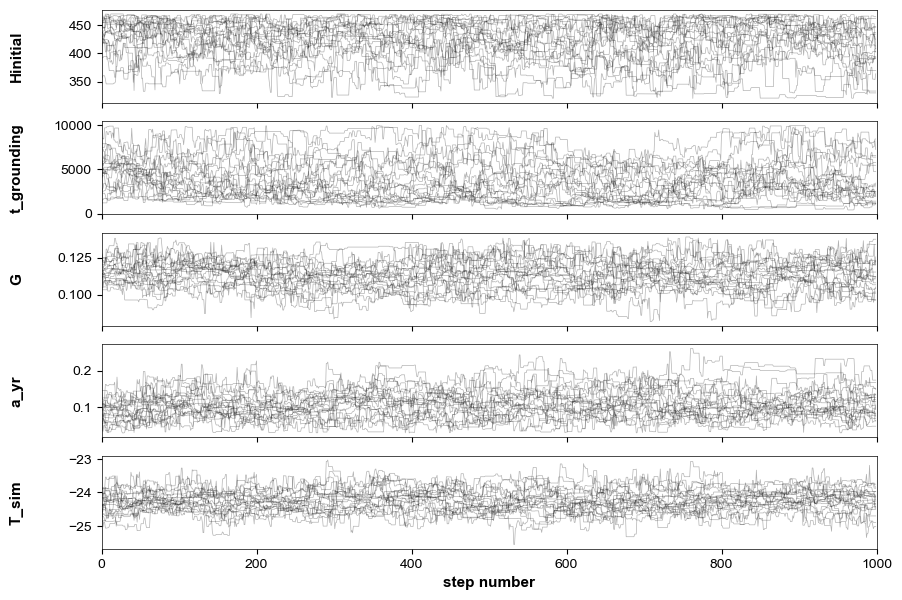

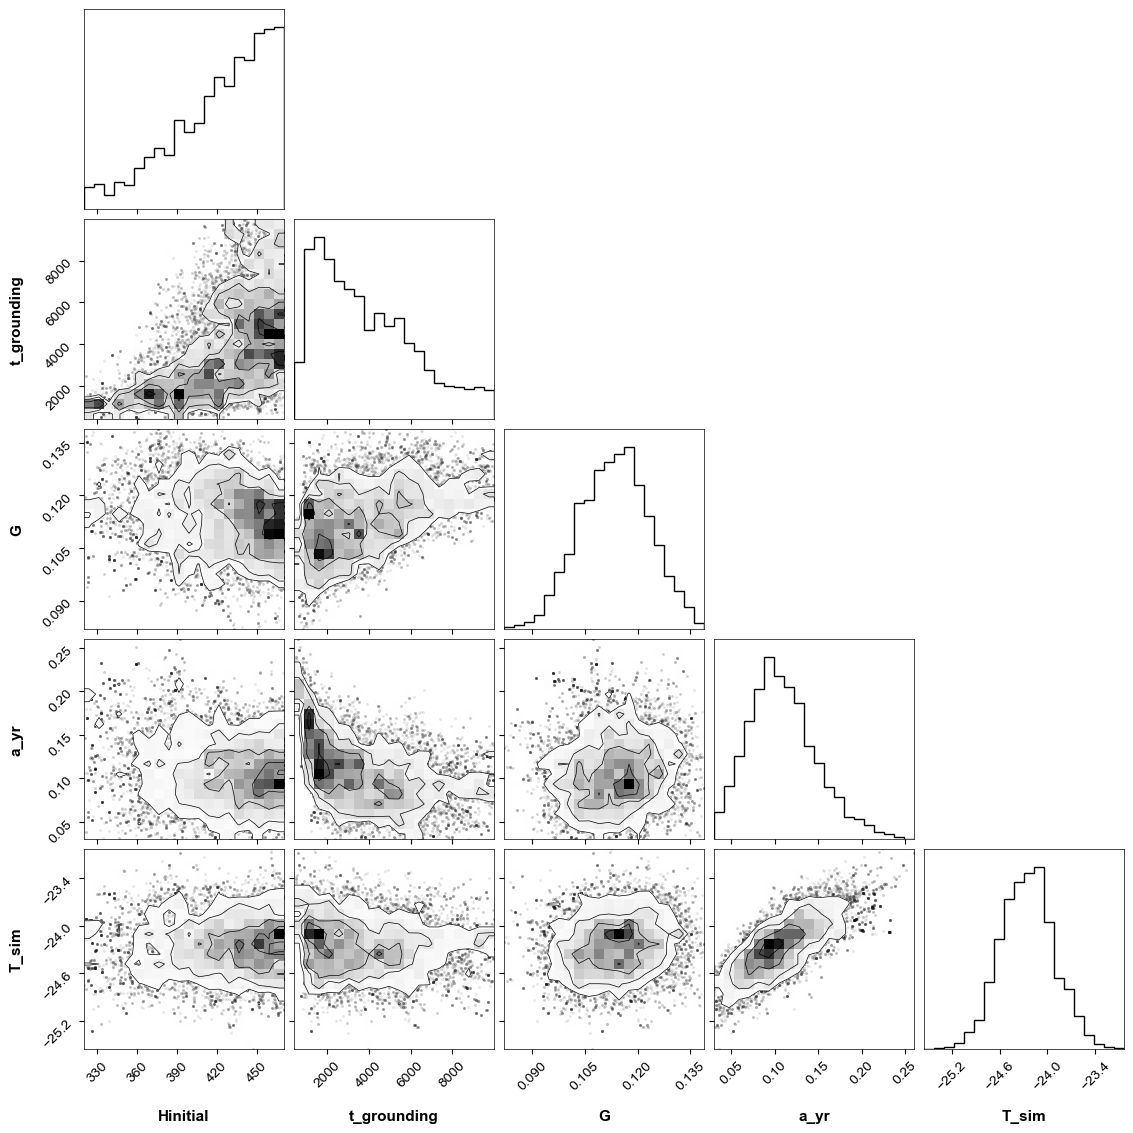

In [10]:
%%time

Terr = 0.05*np.mean(Tmeasured)
data = (z,Tmeasured,Terr)
nwalkers = 20
niter = 1000
initial = np.array([400, 5000, 0.090, 0.15, -25])
ndim = len(initial) # Number of dimensions in the parameter space
p0 = [np.array(initial) + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

from multiprocess import Pool

def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data, pool=pool)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 400, progress=True)
    sampler.reset()
    
    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

with Pool() as pool:
    sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)
 


print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))


fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Hinitial", "t_grounding", "G", "a_yr", "T_sim"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

samples = sampler.flatchain
probabilities = sampler.flatlnprobability

import corner
fig = corner.corner(samples, labels=labels)



np.savetxt('samples_Crary_{initial}_varH_Temp_a_G__tgrounding_Crary_inversion_{walkers}_walkers_{iterations}_iterations.csv'.format(initial = initial, walkers=nwalkers, iterations = niter), samples, delimiter=',')
np.savetxt('probabilities_Crary_{initial}_varH_Temp_a_G__tgrounding_Crary_inversion_{walkers}_walkers_{iterations}_iterations.csv'.format(initial = initial, walkers=nwalkers, iterations = niter), probabilities, delimiter=',')

*Brief interpretations:*

The inversion suggests a relatively recent grounding time of ~2000-6000a, timing that is consistent with the theory of Holocene readvance of Antarctic ice sheet grounding lines.  

The values it gives of other parameters are reasonable and in line with present observed values, including the high heat flow in the region, which suggests that the inversion appears relatively robust.

## Skytrain Ice Rise Inversion

### Resetting the spatial grids

In [14]:
Tmeasured = T_interp_skytrain[0]
z = T_interp_skytrain[1]

Hr = 500
Hend = 630
Hi = 630
dz = 10
z = np.linspace(-int(Hr), int(Hi), int((Hi+Hr)/dz) + 1)   # Space calculation domain for ice and rock
zi = np.linspace(0, Hi, int(Hi/dz) + 1)  # Space calculation domain for ice
zr = np.linspace(-Hr, 0, int(Hr/dz) + 1) #  Space calculation domain for rock
l = len(zr)  # Index for ice-bed interface to be used in the loop calculations
Lz = len(z)  # Number of elements in space domain
Lzi = len(zi) #  Number of elements in space domain for ice
Lzr = len(zr) #  Number of elements in space domain for ice


### Executing MCMC sampling

In [15]:
%%time

def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model_measured(theta, x))/yerr) ** 2)

    
def lnprior(theta):
    Hinitial, t_grounding, G, a_yr, T_sim = theta
    if 250 < Hinitial < 630 and 5 < t_grounding < 15000 and 0.01 < a_yr < 0.3 and -28 < T_sim < -23:
        mu=0.0922
        sigma=0.0186
        Gi = np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(G-mu)**2/sigma**2
        if Gi < 0:
            return -np.inf
        else:
            return Gi
    else:
        return -np.inf
    

def lnprob(theta,x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


CPU times: user 21 µs, sys: 44 µs, total: 65 µs
Wall time: 92 µs


Running burn-in...


100%|███████████████████████████████████████| 350/350 [2:08:22<00:00, 22.01s/it]


Running production...


100%|████████████████████████████████████| 1000/1000 [12:29:05<00:00, 44.95s/it]


Mean acceptance fraction: 0.398
CPU times: user 57.6 s, sys: 7.15 s, total: 1min 4s
Wall time: 14h 38min 23s


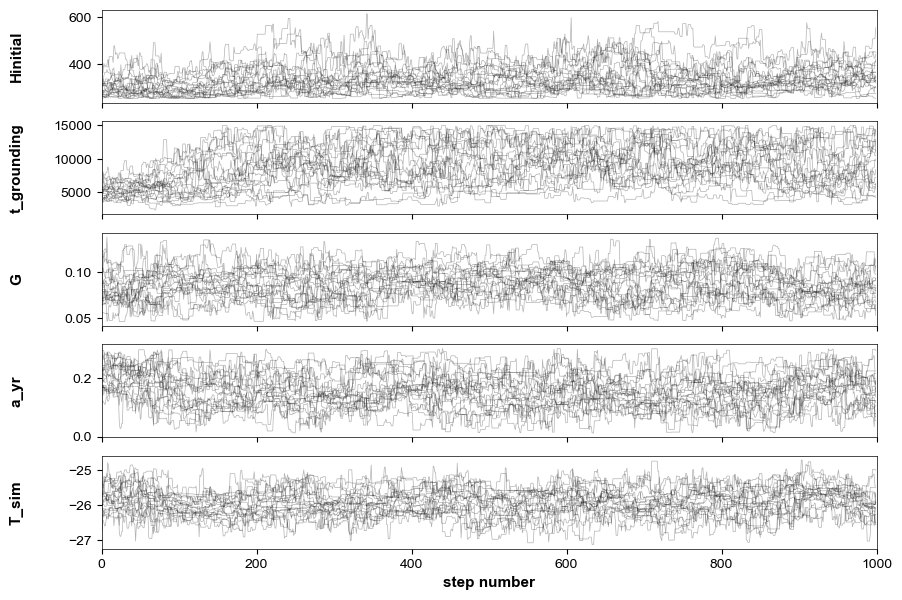

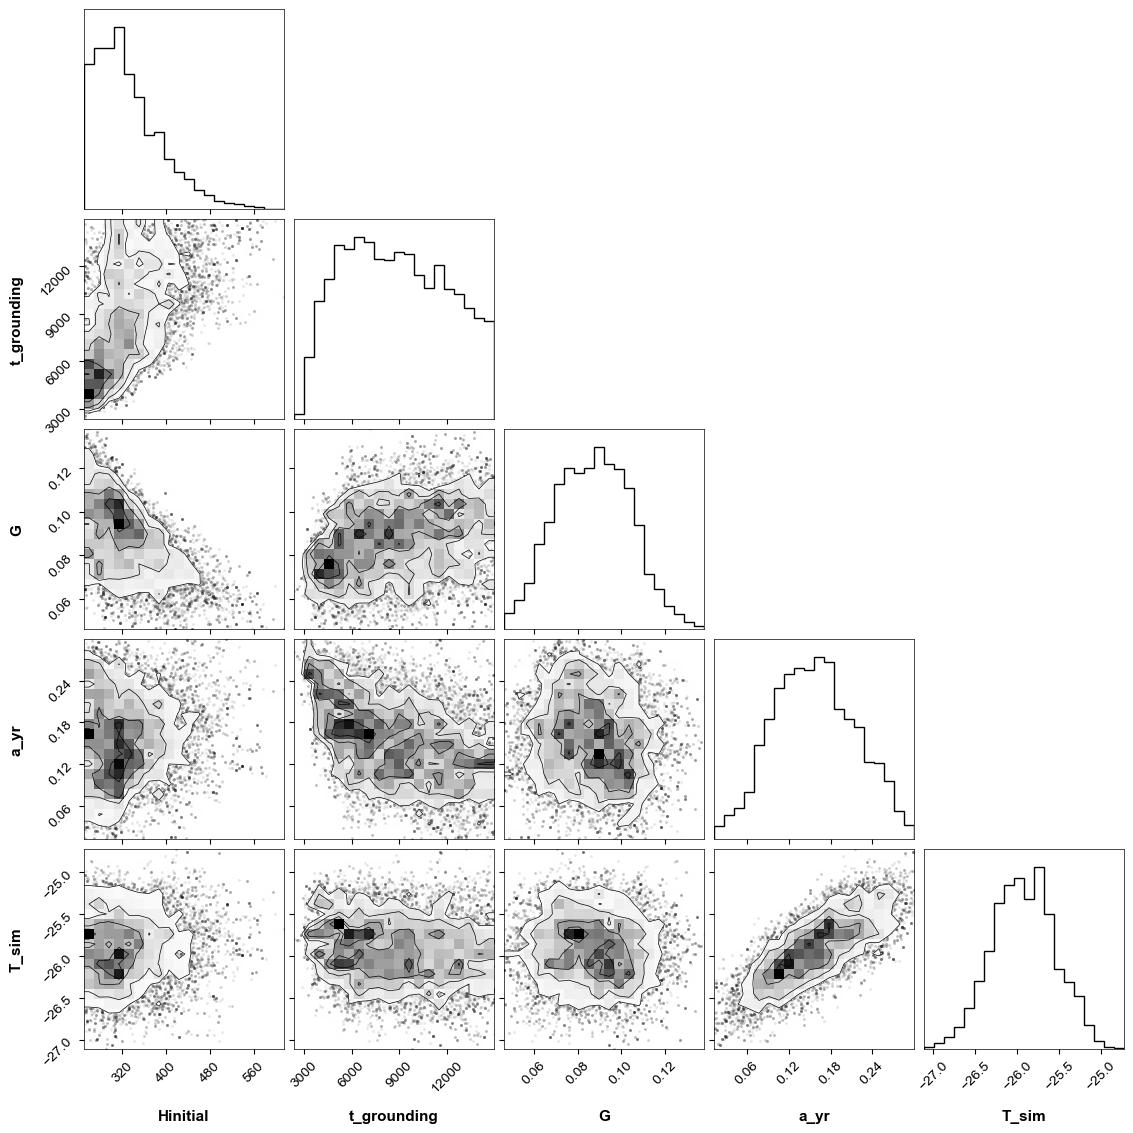

In [55]:
%%time

Terr = 0.05*np.mean(Tmeasured)
data = (z,Tmeasured,Terr)
nwalkers = 20
niter = 1000
initial = np.array([550, 5000, 0.08, 0.16, -26])
ndim = len(initial) # Number of dimensions in the parameter space
p0 = [np.array(initial) + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

from multiprocess import Pool

def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data, pool=pool)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 350, progress=True)
    sampler.reset()
    
    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

with Pool() as pool:
    sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)
 

print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))


fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Hinitial", "t_grounding", "G", "a_yr", "T_sim"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

samples = sampler.flatchain
probabilities = sampler.flatlnprobability


import corner
fig = corner.corner(samples, labels=labels)


np.savetxt('samples_Skytrain_{initial}_varH_Temp_a_G__tgrounding_Skytrain_inversion_{walkers}_walkers_{iterations}_iterations.csv'.format(initial = initial, walkers=nwalkers, iterations = niter), samples, delimiter=',')
np.savetxt('probabilities_Skytrain_{initial}_varH_Temp_a_G__tgrounding_Skytrain_inversion_{walkers}_walkers_{iterations}_iterations.csv'.format(initial = initial, walkers=nwalkers, iterations = niter), probabilities, delimiter=',')

*Brief interpretations:*

The inversion suggests an older grounding time here (Ronne ice shelf region)(in the range of 5000-15000a) compared to Crary (Ross ice shelf region). This is however quite a broad range that could be consistent either with grounding at the end of the last glacial period, or more recently during the possible Holocene readvance. If the former, this would imply that the Holocene retreat did not reach the Skytrain area (if it happened at all).

It's also implied that the ice thickness was initially relatively low compared to the present day (around half) and has increased quite significantly since grounding. Values of heatflow, accumulation rate and surface temperature are reasonable and in line with present observations. 

## Law Dome Inversion

### Resetting the spatial grids

In [23]:
Tmeasured = T_interp_law[0]
z = T_interp_law[1]

Hr = 500
Hend = 1200
Hi = 1200
dz = 10
z = np.linspace(-int(Hr), int(Hi), int((Hi+Hr)/dz) + 1)   # Space calculation domain for ice and rock
zi = np.linspace(0, Hi, int(Hi/dz) + 1)  # Space calculation domain for ice
zr = np.linspace(-Hr, 0, int(Hr/dz) + 1) #  Space calculation domain for rock
l = len(zr)  # Index for ice-bed interface to be used in the loop calculations
Lz = len(z)  # Number of elements in space domain
Lzi = len(zi) #  Number of elements in space domain for ice
Lzr = len(zr) #  Number of elements in space domain for ice


### Executing MCMC sampling

In [24]:
def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model_measured(theta, x))/yerr) ** 2)

    
def lnprior(theta):
    Hinitial, t_grounding, G, a_yr, T_sim = theta
    if 350 < Hinitial < 1200 and 5 < t_grounding < 15000 and 0.1 < a_yr < 0.9 and -23 < T_sim < -19:
        mu=0.0388
        sigma=0.0044
        Gi = np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(G-mu)**2/sigma**2
        if Gi < 0:
            return -np.inf
        else:
            return Gi
    else:
        return -np.inf
    

def lnprob(theta,x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


Running burn-in...


100%|███████████████████████████████████████| 300/300 [1:23:55<00:00, 16.79s/it]


Running production...


100%|████████████████████████████████████| 1000/1000 [13:49:40<00:00, 49.78s/it]


Mean acceptance fraction: 0.494
CPU times: user 47.4 s, sys: 5.17 s, total: 52.6 s
Wall time: 15h 14min 12s


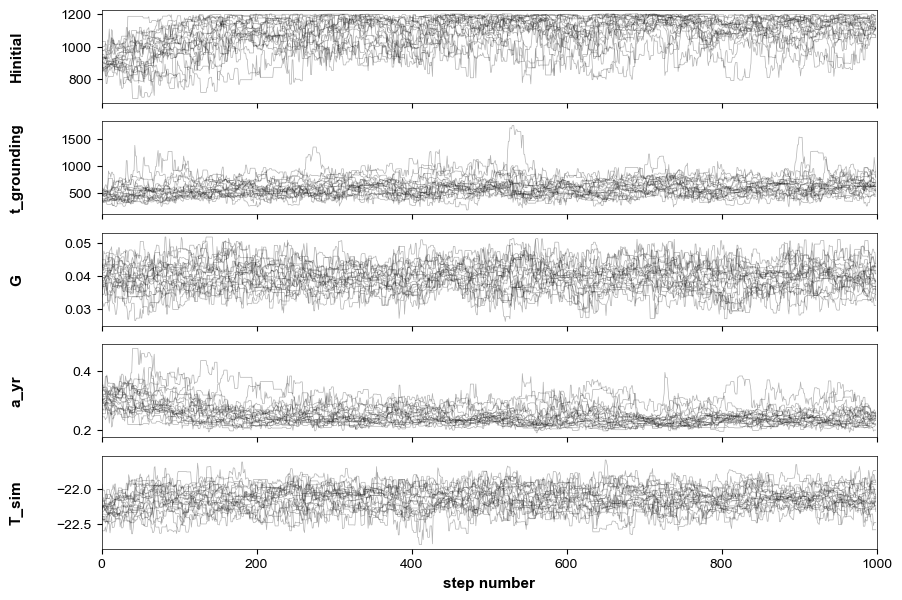

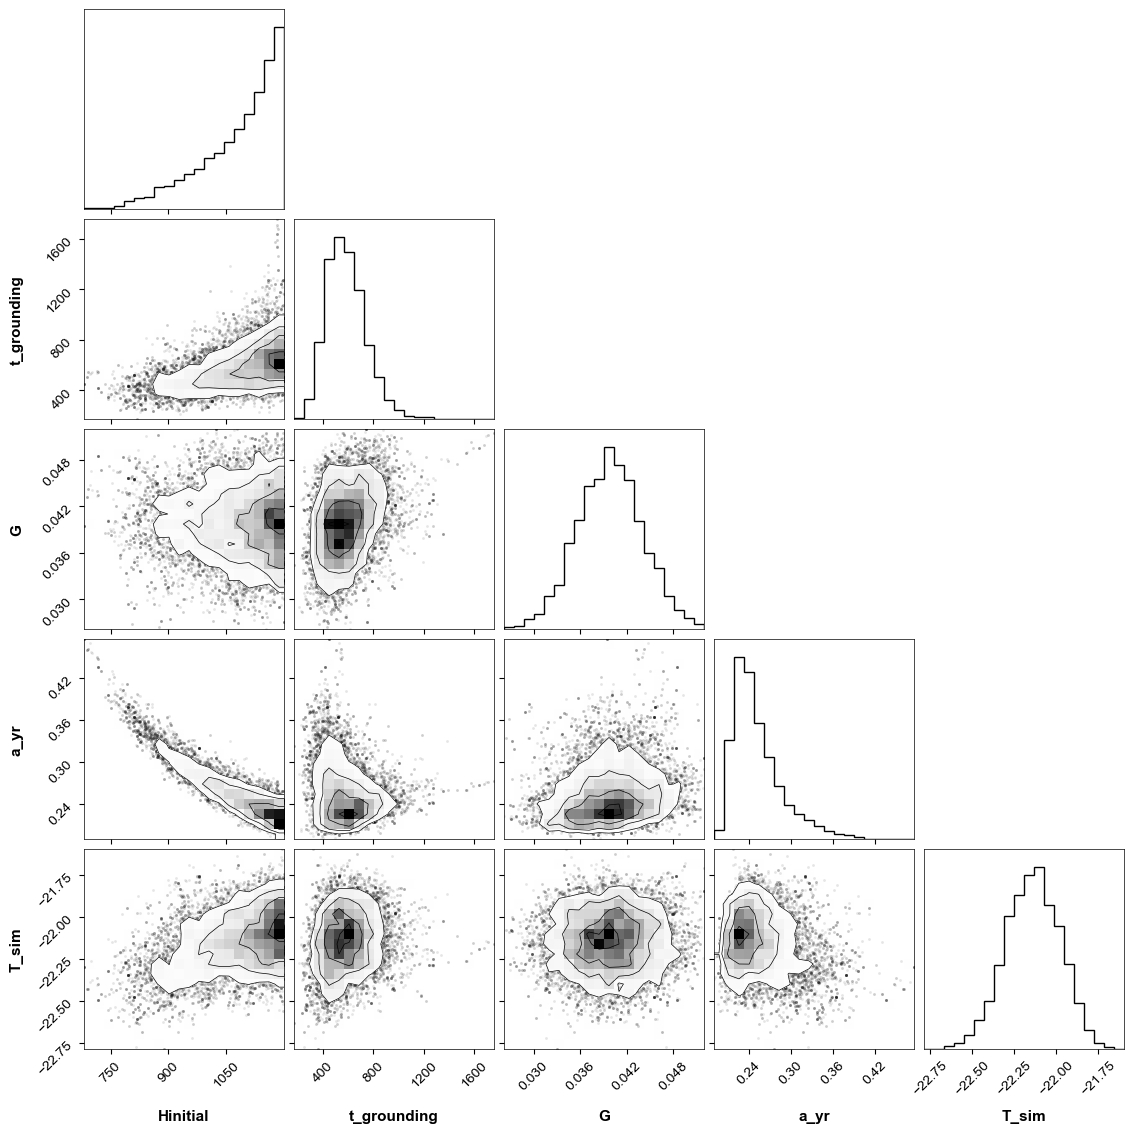

In [27]:
%%time

Terr = 0.05*np.mean(Tmeasured)
data = (z,Tmeasured,Terr)
nwalkers = 20
niter = 1000
initial = np.array([750, 4000, 0.04, 0.5, -21])
ndim = len(initial) # Number of dimensions in the parameter space
p0 = [np.array(initial) + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

from multiprocess import Pool

def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data, pool=pool)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 300, progress=True)
    sampler.reset()
    
    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

with Pool() as pool:
    sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)
 


print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))


fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Hinitial", "t_grounding", "G", "a_yr", "T_sim"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

samples = sampler.flatchain
probabilities = sampler.flatlnprobability


import corner
fig = corner.corner(samples, labels=labels)



np.savetxt('samples_Law_{initial}_varH_Temp_a_G__tgrounding_Law_inversion_{walkers}_walkers_{iterations}_iterations.csv'.format(initial = initial, walkers=nwalkers, iterations = niter), samples, delimiter=',')
np.savetxt('probabilities_Law_{initial}_varH_Temp_a_G__tgrounding_Law_inversion_{walkers}_walkers_{iterations}_iterations.csv'.format(initial = initial, walkers=nwalkers, iterations = niter), probabilities, delimiter=',')

#### 


*Brief interpretations:*  

The inversion tends towards high initial ice thickness and recent grounding time (500-1000 years), even wanting to have an initial thickness greater than the present 1200m.  

Recent (50 year average) accumulation rates here are very high at ~0.5m/yr, and given the lack of any drastic climatic change it would be reasonable to assume that this has remained relatively constant since grounding. The inversion gives a mean accumulation value which is about half this, which may suggest that the recent grounding time and high initial thickness are also erroneous and that the assumptions made in the model are simply not applicable at this location, or that accumulation rate has in fact changed thorugh time.  

Alternatively, the ice sheet could have started with thickness greater than today, and lost thickness, potentially as a result of horizontal ice flow, which is recorded to be 2.6m/yr in a 220deg direction, but this is probably unlikely to have a significant enough effect to entirely compensate the high accumulation rate and result in a net decrease in ice thickness.  

However, if this inversion is robust, the recent grounding time could suggest a dominant GIA influence in this region (mantle more viscous in EA therefore ongoing (slower rate of) GIA since LGM), as there has been little climatic change in the past 500-1000 years to have caused significant ice growth.

## Siple Dome Inversion

(Below is the code to run the inversion for Siple Dome, but current inital values and prior bounds of parameters are not fine-tuned; have not yet done a full run to produce interpretable results)

### Resetting the spatial grids

In [17]:
Tmeasured = T_interp_siple[0]
z = T_interp_siple[1]

Hr = 500
Hend = 1010
Hi = 1010
dz = 10
z = np.linspace(-int(Hr), int(Hi), int((Hi+Hr)/dz) + 1)   # Space calculation domain for ice and rock
zi = np.linspace(0, Hi, int(Hi/dz) + 1)  # Space calculation domain for ice
zr = np.linspace(-Hr, 0, int(Hr/dz) + 1) #  Space calculation domain for rock
l = len(zr)  # Index for ice-bed interface to be used in the loop calculations
Lz = len(z)  # Number of elements in space domain
Lzi = len(zi) #  Number of elements in space domain for ice
Lzr = len(zr) #  Number of elements in space domain for ice


### Executing MCMC sampling

In [18]:
def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model_measured(theta, x))/yerr) ** 2)

    
def lnprior(theta):
    Hinitial, t_grounding, G, a_yr, T_sim = theta
    if 350 < Hinitial < 1010 and 5 < t_grounding < 17000 and 0.01 < a_yr < 0.4 and -27 < T_sim < -23:
        mu=0.1061
        sigma=0.0100
        Gi = np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(G-mu)**2/sigma**2
        if Gi < 0:
            return -np.inf
        else:
            return Gi
    else:
        return -np.inf
    

def lnprob(theta,x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


Running burn-in...


100%|███████████████████████████████████████████| 10/10 [02:22<00:00, 14.25s/it]


Running production...


100%|█████████████████████████████████████████| 200/200 [46:12<00:00, 13.86s/it]


Mean acceptance fraction: 0.559


CPU times: user 4.96 s, sys: 758 ms, total: 5.72 s
Wall time: 48min 58s


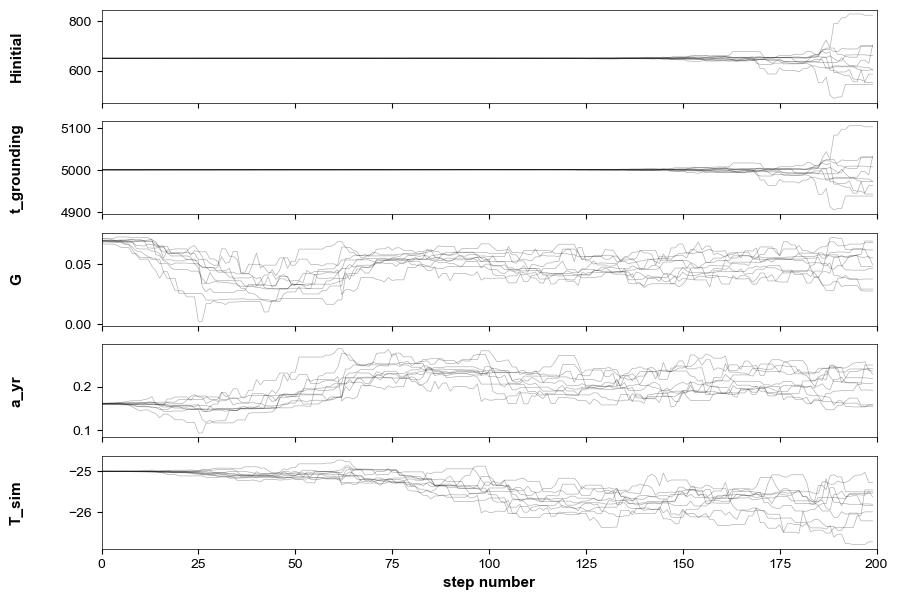

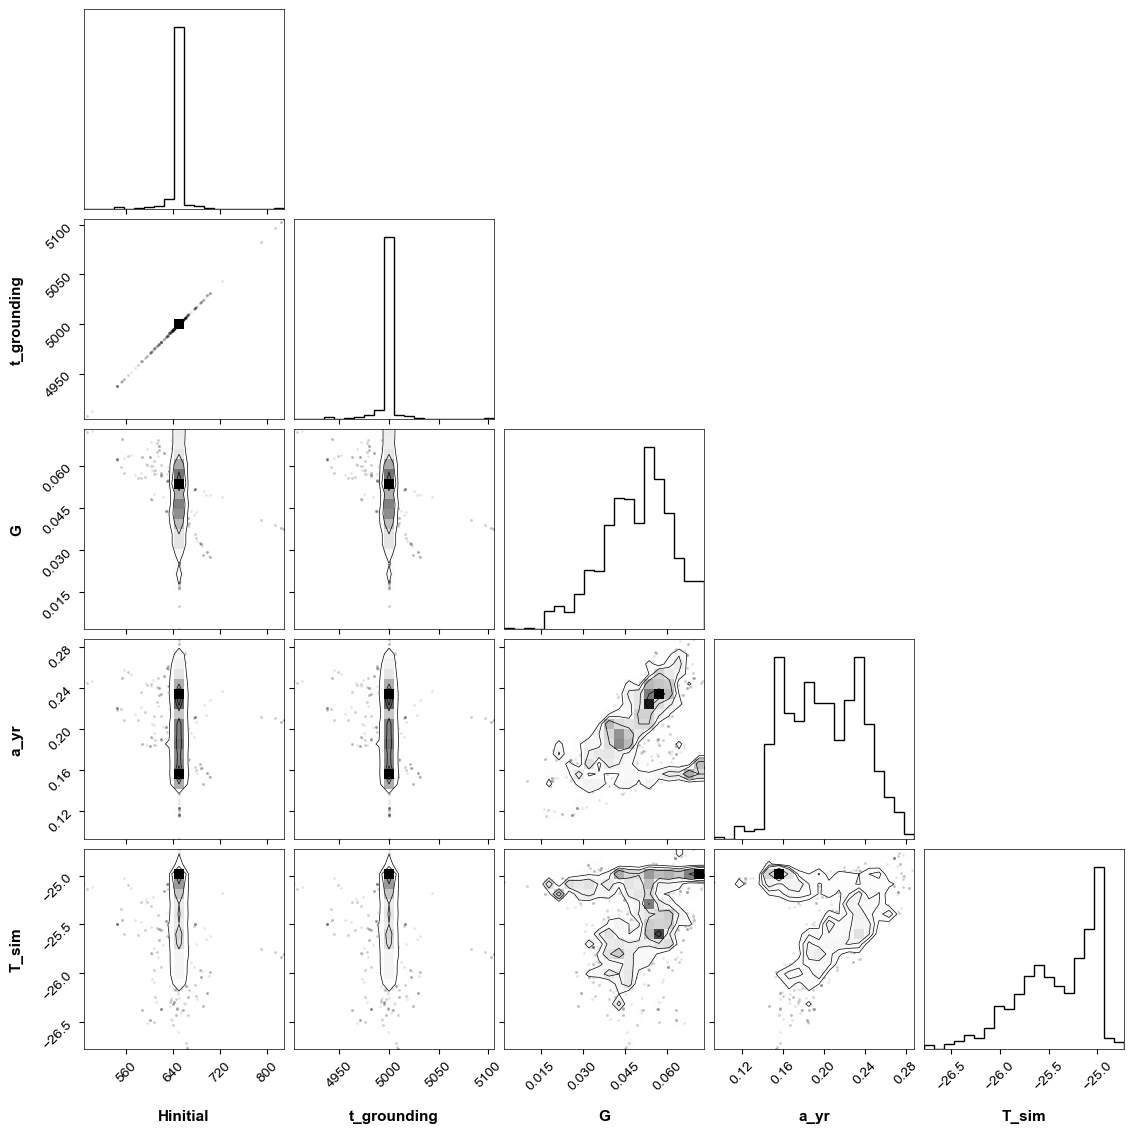

In [73]:
%%time

Terr = 0.05*np.mean(Tmeasured)
data = (z,Tmeasured,Terr)
nwalkers = 10
niter = 200
initial = np.array([650, 5000, 0.070, 0.16, -25])
ndim = len(initial) # Number of dimensions in the parameter space
p0 = [np.array(initial) + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

from multiprocess import Pool

def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data, pool=pool)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 10, progress=True)
    sampler.reset()
    
    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

with Pool() as pool:
    sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)
    

print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))


fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Hinitial", "t_grounding", "G", "a_yr", "T_sim"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

samples = sampler.flatchain
probabilities = sampler.flatlnprobability


import corner
fig = corner.corner(samples, labels=labels)

np.savetxt('samples_Siple_{initial}_varH_Temp_a_G__tgrounding_Siple_inversion_{walkers}_walkers_{iterations}_iterations.csv'.format(initial = initial, walkers=nwalkers, iterations = niter), samples, delimiter=',')
np.savetxt('probabilities_Siple_{initial}_varH_Temp_a_G__tgrounding_Siple_inversion_{walkers}_walkers_{iterations}_iterations.csv'.format(initial = initial, walkers=nwalkers, iterations = niter), probabilities, delimiter=',')

## Fletcher Promontory Inversion

(Below is the code to run the inversion for Fletcher Promontory, but current inital values and prior bounds of parameters are not fine-tuned; have not yet done a full run to produce interpretable results)

### Resetting the spatial grids

In [19]:
Tmeasured = T_interp_fletcher[0]
z = T_interp_fletcher[1]

Hr = 500
Hend = 660
Hi = 660
dz = 10
z = np.linspace(-int(Hr), int(Hi), int((Hi+Hr)/dz) + 1)   # Space calculation domain for ice and rock
zi = np.linspace(0, Hi, int(Hi/dz) + 1)  # Space calculation domain for ice
zr = np.linspace(-Hr, 0, int(Hr/dz) + 1) #  Space calculation domain for rock
l = len(zr)  # Index for ice-bed interface to be used in the loop calculations
Lz = len(z)  # Number of elements in space domain
Lzi = len(zi) #  Number of elements in space domain for ice
Lzr = len(zr) #  Number of elements in space domain for ice


### Executing MCMC sampling

In [20]:
def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model_measured(theta, x))/yerr) ** 2)

    
def lnprior(theta):
    Hinitial, t_grounding, G, a_yr, T_sim = theta
    if 350 < Hinitial < 660 and 5 < t_grounding < 17000 and 0.01 < a_yr < 0.4 and -29 < T_sim < -25:
        mu=0.0811
        sigma=0.0189
        Gi = np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(G-mu)**2/sigma**2
        if Gi < 0:
            return -np.inf
        else:
            return Gi
    else:
        return -np.inf
    

def lnprob(theta,x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


Running burn-in...


100%|███████████████████████████████████████████| 10/10 [02:09<00:00, 12.94s/it]


Running production...


100%|█████████████████████████████████████████| 200/200 [47:53<00:00, 14.37s/it]


Mean acceptance fraction: 0.521
CPU times: user 4.98 s, sys: 676 ms, total: 5.65 s
Wall time: 50min 27s


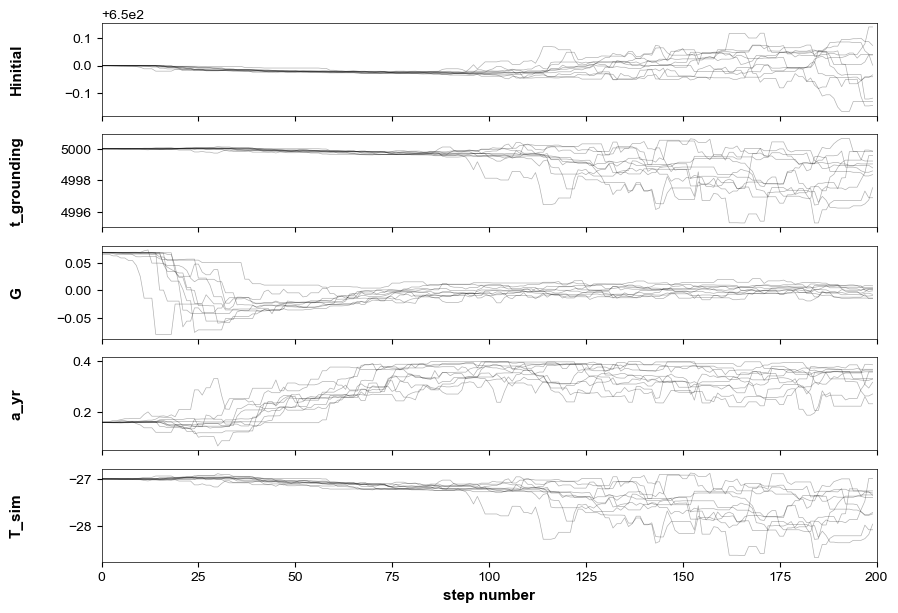

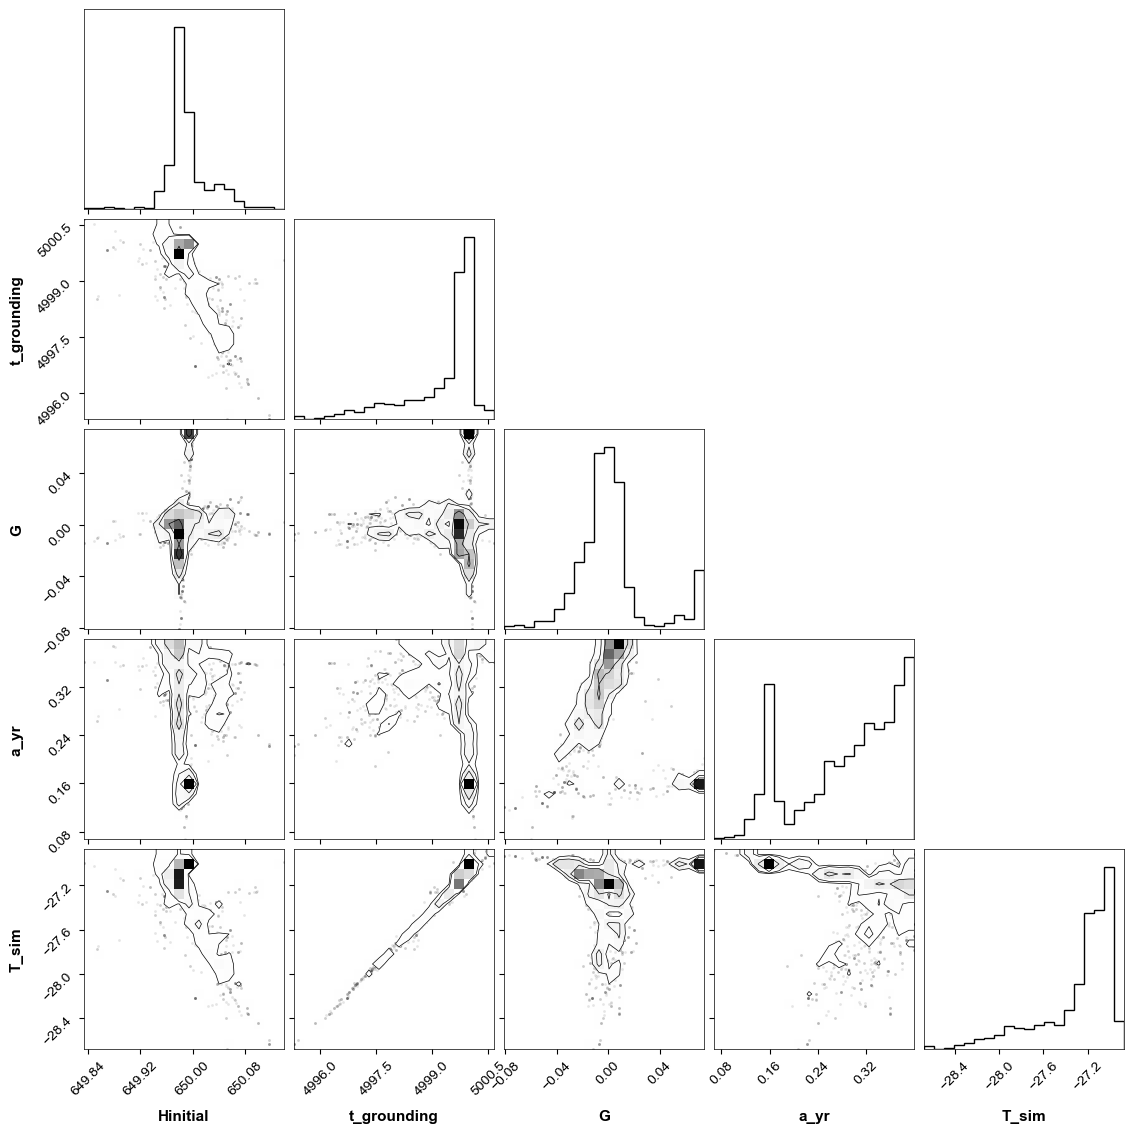

In [83]:
%%time

Terr = 0.05*np.mean(Tmeasured)
data = (z,Tmeasured,Terr)
nwalkers = 10
niter = 200
initial = np.array([650, 5000, 0.070, 0.16, -27])
ndim = len(initial) # Number of dimensions in the parameter space
p0 = [np.array(initial) + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

from multiprocess import Pool

def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data, pool=pool)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 10, progress=True)
    sampler.reset()
    
    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

with Pool() as pool:
    sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)
 


print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))


fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Hinitial", "t_grounding", "G", "a_yr", "T_sim"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

samples = sampler.flatchain
probabilities = sampler.flatlnprobability


import corner
fig = corner.corner(samples, labels=labels)



np.savetxt('samples_Fletcher_{initial}_varH_Temp_a_G__tgrounding_Fletcher_inversion_{walkers}_walkers_{iterations}_iterations.csv'.format(initial = initial, walkers=nwalkers, iterations = niter), samples, delimiter=',')
np.savetxt('probabilities_Fletcher_{initial}_varH_Temp_a_G__tgrounding_Fletcher_inversion_{walkers}_walkers_{iterations}_iterations.csv'.format(initial = initial, walkers=nwalkers, iterations = niter), probabilities, delimiter=',')

## Berkner Island Inversion

(Below is the code to run the inversion for Berkner Island, but current inital values and prior bounds of parameters are not fine-tuned; have not yet done a full run to produce interpretable results)

### Resetting the spatial grids

In [21]:
Tmeasured = T_interp_berkner[0]
z = T_interp_berkner[1]

Hr = 500
Hend = 940
Hi = 940
dz = 10
z = np.linspace(-int(Hr), int(Hi), int((Hi+Hr)/dz) + 1)   # Space calculation domain for ice and rock
zi = np.linspace(0, Hi, int(Hi/dz) + 1)  # Space calculation domain for ice
zr = np.linspace(-Hr, 0, int(Hr/dz) + 1) #  Space calculation domain for rock
l = len(zr)  # Index for ice-bed interface to be used in the loop calculations
Lz = len(z)  # Number of elements in space domain
Lzi = len(zi) #  Number of elements in space domain for ice
Lzr = len(zr) #  Number of elements in space domain for ice


### Executing MCMC sampling

In [22]:
def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model_measured(theta, x))/yerr) ** 2)

    
def lnprior(theta):
    Hinitial, t_grounding, G, a_yr, T_sim = theta
    if 350 < Hinitial < 940 and 5 < t_grounding < 17000 and 0.01 < a_yr < 0.4 and -27 < T_sim < -23:
        mu=0.0678
        sigma=0.0182
        Gi = np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(G-mu)**2/sigma**2
        if Gi < 0:
            return -np.inf
        else:
            return Gi
    else:
        return -np.inf
    

def lnprob(theta,x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


Running burn-in...


100%|███████████████████████████████████████████| 10/10 [02:25<00:00, 14.58s/it]


Running production...


100%|█████████████████████████████████████████| 100/100 [25:50<00:00, 15.50s/it]


Mean acceptance fraction: 0.560
CPU times: user 3.05 s, sys: 470 ms, total: 3.52 s
Wall time: 28min 41s


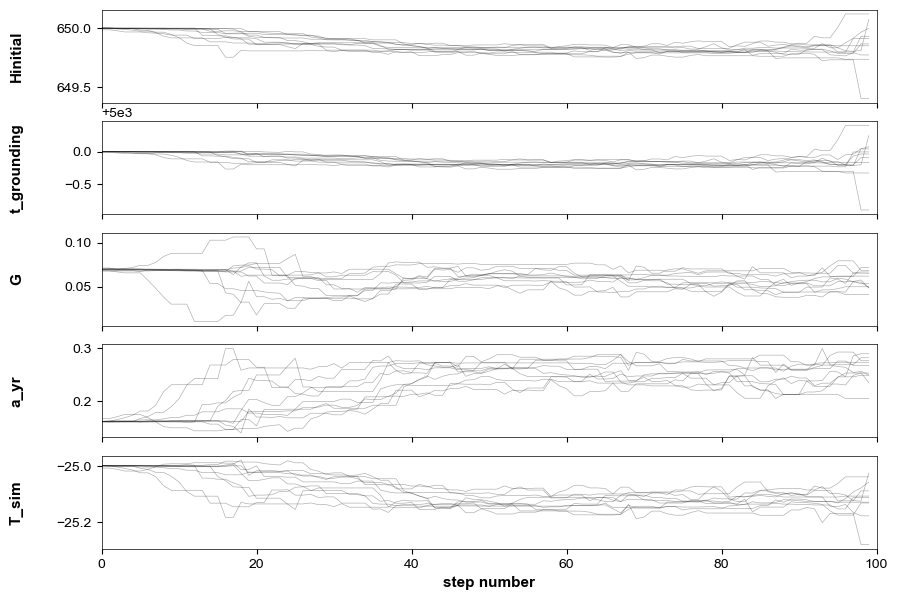

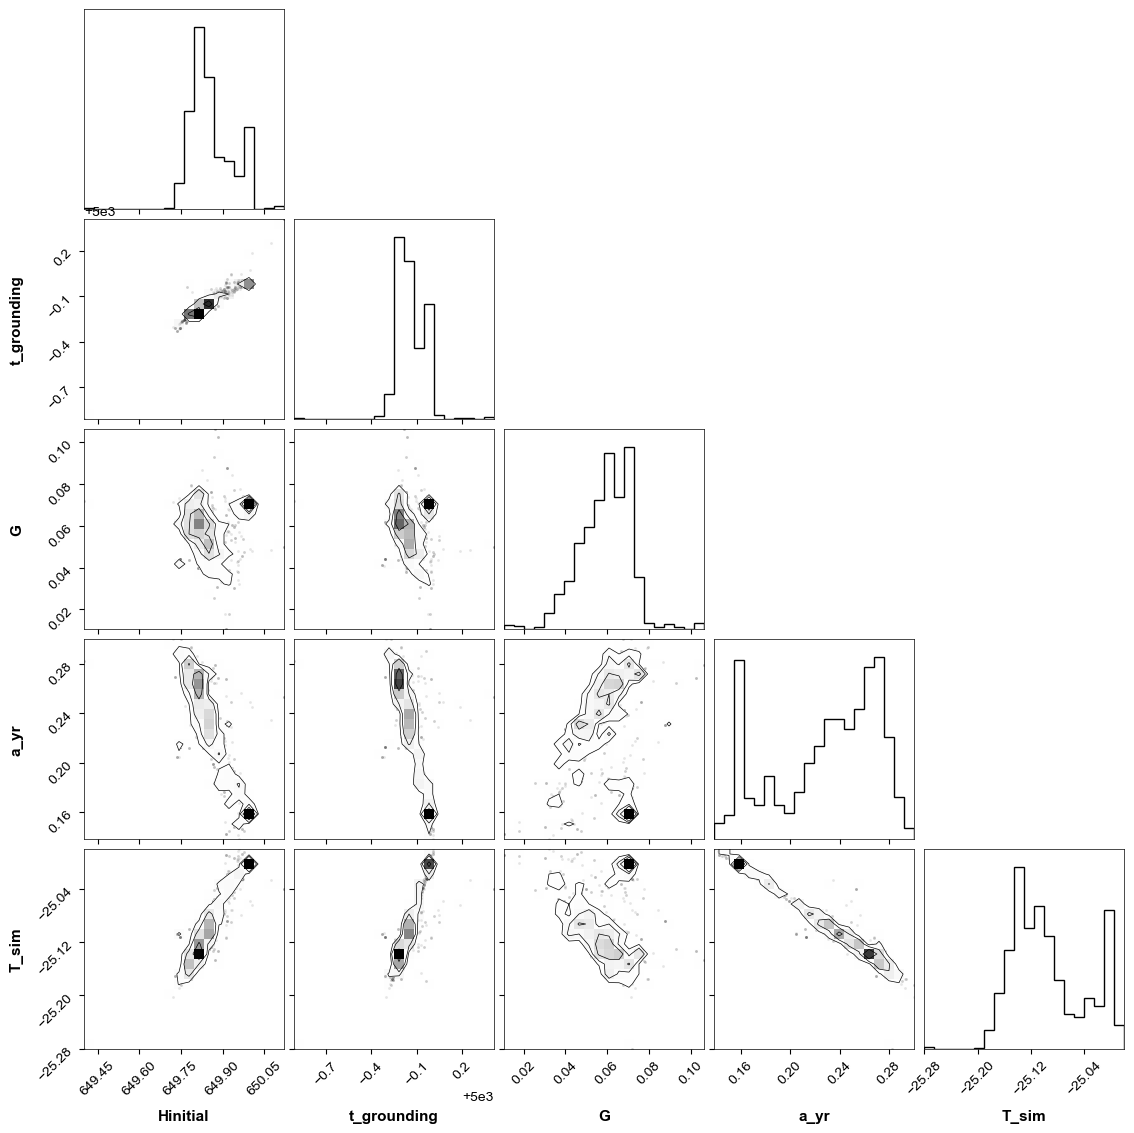

In [54]:
%%time

Terr = 0.05*np.mean(Tmeasured)
data = (z,Tmeasured,Terr)
nwalkers = 10
niter = 100
initial = np.array([650, 5000, 0.070, 0.16, -25])
ndim = len(initial) # Number of dimensions in the parameter space
p0 = [np.array(initial) + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

from multiprocess import Pool

def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data, pool=pool)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 10, progress=True)
    sampler.reset()
    
    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

with Pool() as pool:
    sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)
 


print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

#tau = sampler.get_autocorr_time()
#print(tau)

fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Hinitial", "t_grounding", "G", "a_yr", "T_sim"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

samples = sampler.flatchain
probabilities = sampler.flatlnprobability


import corner
fig = corner.corner(samples, labels=labels)



np.savetxt('samples_Berkner_w_iceshelf_narrowed_{initial}_varH_Temp_a_G__tgrounding_Berkner_inversion_{walkers}_walkers_{iterations}_iterations.csv'.format(initial = initial, walkers=nwalkers, iterations = niter), samples, delimiter=',')
np.savetxt('probabilities_Berkner_w_iceshelf_narrowed_{initial}_varH_Temp_a_G__tgrounding_Berkner_inversion_{walkers}_walkers_{iterations}_iterations.csv'.format(initial = initial, walkers=nwalkers, iterations = niter), probabilities, delimiter=',')